## Designing crossovers using Linkwitz-Riley filters

HTML output built with: jupyter nbconvert --to html crossover.ipynb


In [17]:
from importnb import Notebook
with Notebook(): 
        import svfbode
import matplotlib.pyplot as plt
from math import *
import cmath

Q_BUTTERWORTH = 0.707106769
FS = 96000

In [18]:
def plot_amp_phase_func(func, lim = (-12, 12)):
    amplitude = []
    phase = []
    x = []
    for i in range(20, 20000, 10):
        n = func(i)
        amplitude.append(svfbode.db_from_lin(abs(n).real))
        phase.append(degrees(cmath.phase(n)))
        x.append(i)

    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.semilogx(x, amplitude)
    ax1.set_ylabel("amplitude")
    ax1.set_ylim(lim)

    ax2 = ax1.twinx()
    ax2.semilogx(x, phase, "r-")
    ax2.set_ylabel("phase", color="r") 
    ax2.set_ylim([-180, 180])
    
    plt.xlim([20, 20000])
    #plt.show()

Mixing butterworth lowpass and highpass filters results in a bump or dip in frequency response

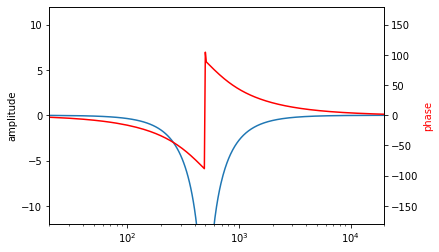

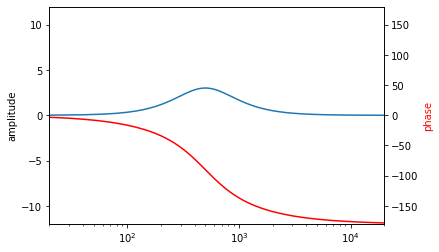

In [19]:

lpf = svfbode.lowpass(500, Q_BUTTERWORTH, FS)
hpf = svfbode.highpass(500, Q_BUTTERWORTH, FS)
plot_amp_phase_func(lambda f_hz: svfbode.svf_bode_digital(f_hz, lpf, FS) +
                                 svfbode.svf_bode_digital(f_hz, hpf, FS) )
plot_amp_phase_func(lambda f_hz: svfbode.svf_bode_digital(f_hz, lpf, FS) -
                                 svfbode.svf_bode_digital(f_hz, hpf, FS) )

Fourth-order Linkwitz–Riley crossovers (LR4) are constructed by cascading two 2nd-order Butterworth filters

In [20]:
def LR4(coeffs):
    def filter_func(f_hz):
        y = 1
        y *= svfbode.svf_bode_digital(f_hz, coeffs, FS)
        y *= svfbode.svf_bode_digital(f_hz, coeffs, FS)
        return y
    return filter_func

Linkwitz–Riley filters have −6 dB gain at cuttoff and when mixed they result in an all pass filter.

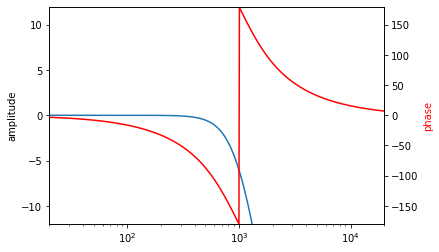

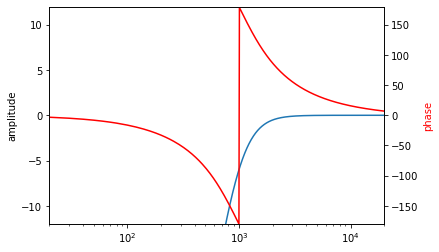

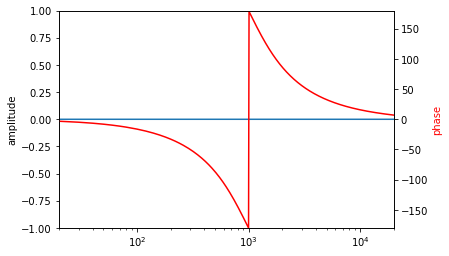

In [21]:

lpf = LR4(svfbode.lowpass(1000, Q_BUTTERWORTH, FS))
hpf = LR4(svfbode.highpass(1000, Q_BUTTERWORTH, FS))

plot_amp_phase_func(lpf)
plot_amp_phase_func(hpf)
plot_amp_phase_func(lambda f_hz: lpf(f_hz) + hpf(f_hz), (-1,1))

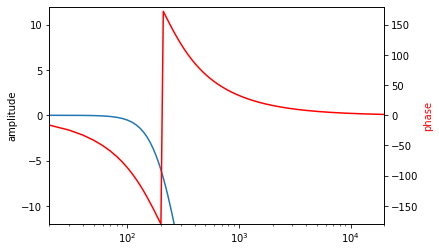

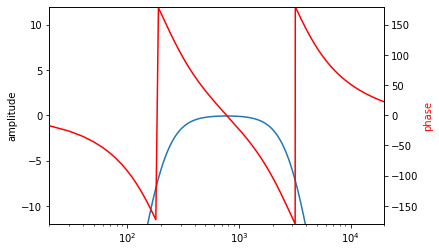

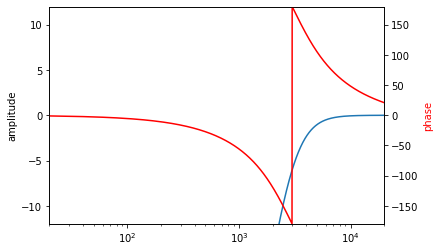

In [22]:
band1_lpf = LR4(svfbode.lowpass(200, Q_BUTTERWORTH, FS))
band2_hpf = LR4(svfbode.highpass(200, Q_BUTTERWORTH, FS))
band2_lpf = LR4(svfbode.lowpass(3000, Q_BUTTERWORTH, FS))
band3_hpf = LR4(svfbode.highpass(3000, Q_BUTTERWORTH, FS))

plot_amp_phase_func(band1_lpf)
plot_amp_phase_func(lambda f_hz: band2_hpf(f_hz) * band2_lpf(f_hz))
plot_amp_phase_func(band3_hpf)

When there are 3 bands, the middle band has both a highpass and lowpass bringing that band out of phase with the others. This results in dips at each crossover. 

The dips are small with Fourth-order Linkwitz–Riley filters, but are more pronounced with higher order filters.

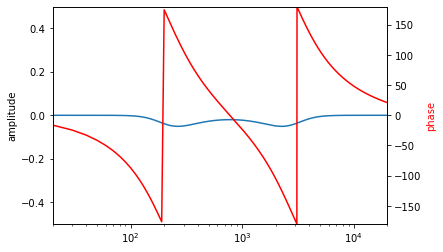

In [23]:
plot_amp_phase_func(lambda f_hz: band1_lpf(f_hz) + 
                                 band2_hpf(f_hz) * band2_lpf(f_hz) + 
                                 band3_hpf(f_hz), 
                                 (-0.5,0.5))

This can be corrected by using corresponding all pass filters.

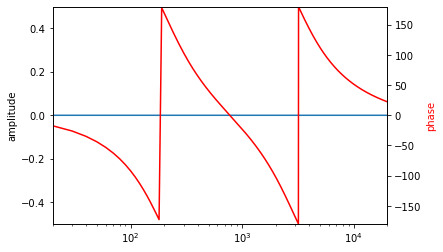

In [24]:

band1_apf = svfbode.allpass(3000, Q_BUTTERWORTH, FS)
band3_apf = svfbode.allpass(200, Q_BUTTERWORTH, FS)

def crossover(f_hz):
    y = 0
    y += band1_lpf(f_hz) * svfbode.svf_bode_digital(f_hz, band1_apf, FS)
    y += band2_hpf(f_hz) * band2_lpf(f_hz)
    y += band3_hpf(f_hz) * svfbode.svf_bode_digital(f_hz, band3_apf, FS)
    return y

plot_amp_phase_func(crossover, (-0.5,0.5))

In [25]:
def butterworth_cascade_q(filter_order, pole):
    pole_inc = pi / filter_order
    even_order = filter_order % 2 == 0

    if even_order:
        first_angle = pole_inc * 0.5
    else:
        if pole == 0: 
            return 0.5 #Also needs to be 1 pole (not biquad)
        pole -= 1
        first_angle = pole_inc
    
    return 1.0 / (2.0 * cos(first_angle + pole * pole_inc))


In [26]:
def cascade_butterworth(f0, coeffs_func, fs, order):
    filters = []
    for filter_n in range(1, int(order / 2) + 1):
        pole = filter_n * 2 #We are cascading 2nd order filters
        q = butterworth_cascade_q(order, pole)
        filters.append(coeffs_func(f0, q, fs))

    def filter_func(f_hz):
        y = 1
        for fltr in filters:
            y *= svfbode.svf_bode_digital(f_hz, fltr, FS)
        return y
    return filter_func


8th order butterworth


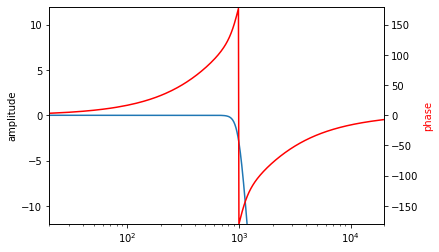

In [27]:
lpf = cascade_butterworth(1000, svfbode.lowpass, FS, 8)
plot_amp_phase_func(lpf)

In [28]:
def LR_order(f0, filter_func, order):
    main_filter = cascade_butterworth(f0, filter_func, FS, order/2)
    def filter_func(f_hz):
        return main_filter(f_hz) * main_filter(f_hz)
    return filter_func

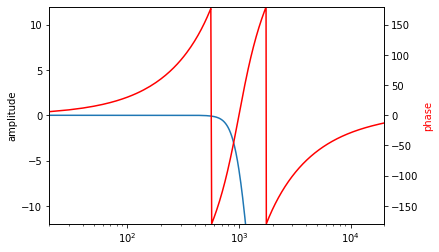

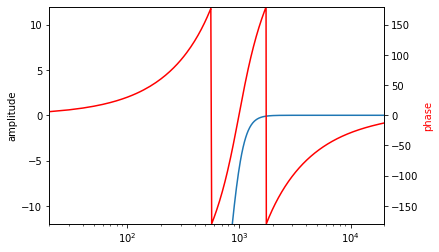

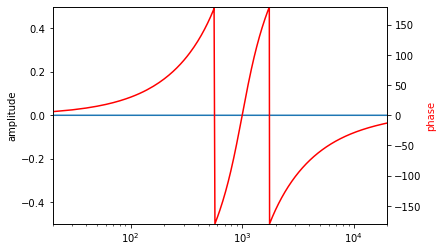

In [29]:
lpf = LR_order(1000, svfbode.lowpass, 8)
hpf = LR_order(1000, svfbode.highpass, 8)

plot_amp_phase_func(lpf)
plot_amp_phase_func(hpf)
plot_amp_phase_func(lambda f_hz: lpf(f_hz) + hpf(f_hz), (-0.5,0.5))

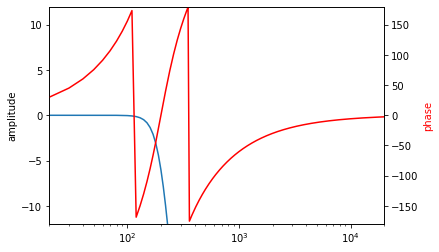

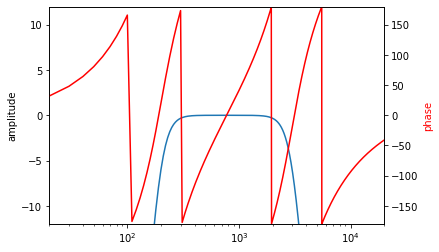

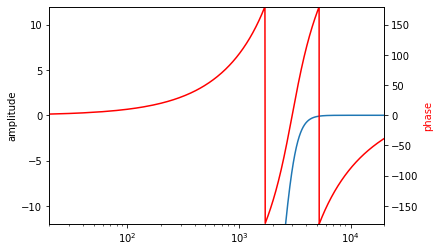

In [30]:
band1_lpf = LR_order(200, svfbode.lowpass, 8)
band2_hpf = LR_order(200, svfbode.highpass, 8)
band2_lpf = LR_order(3000, svfbode.lowpass, 8)
band3_hpf = LR_order(3000, svfbode.highpass, 8)

plot_amp_phase_func(band1_lpf)
plot_amp_phase_func(lambda f_hz: band2_hpf(f_hz) * band2_lpf(f_hz))
plot_amp_phase_func(band3_hpf)

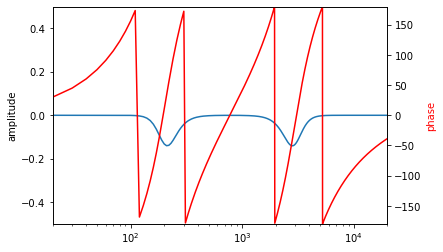

In [31]:
plot_amp_phase_func(lambda f_hz: band1_lpf(f_hz) + 
                                 band2_hpf(f_hz) * band2_lpf(f_hz) + 
                                 band3_hpf(f_hz), 
                                 (-0.5,0.5))

Corrected by using corresponding all pass filters.

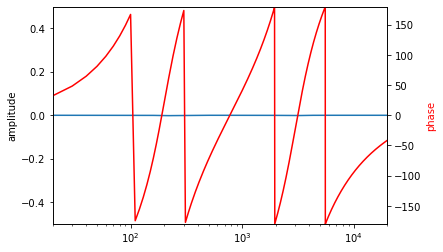

In [32]:
band1_apf = cascade_butterworth(3000, svfbode.allpass, FS, 8)
band3_apf = cascade_butterworth(200, svfbode.allpass, FS, 8)

def crossover(f_hz):
    y = 0
    y += band1_lpf(f_hz) * band1_apf(f_hz)
    y += band2_hpf(f_hz) * band2_lpf(f_hz)
    y += band3_hpf(f_hz) * band3_apf(f_hz)
    return y

plot_amp_phase_func(crossover, (-0.5,0.5))